In [1]:
# Packages for CNN
import os, math, csv, scipy, time, random, tensorflow
import numpy as np, nibabel as nib, seaborn as sns, matplotlib.pyplot as plt, pandas as pd
from statannot import add_stat_annotation
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import SGD, Adam, schedules
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras import regularizers, Input
from sklearn import linear_model
from sklearn.metrics import roc_curve, auc, confusion_matrix

In [2]:
def load_brain_with_vol(dirPath, dirList):
    
    brains_comb = np.empty(shape=(0,160,9,160)) # store the brain image
#     vol_vect = np.empty(shape=(0,2)) # store the hippocampal volumes
    
    # Loops through all the different sites listed
    for d in dirList:
        
        # Get the full path to the site's images
        dirPath_full = dirPath+d
        print(dirPath_full)
        
        # Get the full path to the site's hippocampal volume file
        filePath_vol = dirPath + '../stats/icv_vol_' + d +'.csv'
        print(filePath_vol)
        
        # Open the volume file and load the volumes
        with open(filePath_vol) as file_name:
            array = np.loadtxt(file_name, delimiter=",")
            hippL = array[:,0]
            hippR = array[:,1]
            icv = array[:,2]
            asym = array[:,3]
        
        # Open the site's image dir
        for (root, dirs, files) in os.walk(dirPath_full):
    
            numFiles = len(files) # get number of files in the dir
            brains = np.zeros(shape=(numFiles, 160, 9, 160)) # stores all the brains
            
            # Loop through all the files and load each nifti file
            for i in range(numFiles):
            
                img = nib.load(dirPath_full+"/"+files[i]).get_fdata() # load the subject brain
                brains[i,:,:7,:] = img[5:165,[84,87,90,96,99,102,108],4:164]
            
        # Min shifts the data
        brains[brains == 0] = np.nan # set all non-brain voxel to NaNs
        brains = brains - np.nanmean(brains) # subtract by the mean of all brain voxel from the site
        brains = brains + np.abs(-0.5566426730982418) # add back the minimum value to make sure that all sites are above 0
        brains[np.isnan(brains)] = 0 # reset all non-brain voxel from NaNs to 0
        
        # Loop through the files to add in the volumes channels and other channels
        for i in range(numFiles):
            slice1 = np.full((160,160), hippL[i]) # create a channel where every pixel is the left hippocampal vol value
            slice2 = np.full((160,160), hippR[i]) # create a channel where every pixel is the right hippocampal vol value
            slice3 = slice1/icv[i] # create the icv adjusted left hippocampal vol channel
            slice4 = slice2/icv[i] # create the icv adjusted right hippocampal vol channel
            slice5 = np.full((160,160), asym[i]) # create a channel where every pixel is the asymmetry value
            # Put all the extra channels into the brain vector
            brains[i,:,7,:] = slice1 
            brains[i,:,8,:] = slice2
#             brains[i,:,9,:] = slice3
#             brains[i,:,10,:] = slice4
#             brains[i,:,11,:] = slice5
        
        # Join the brains and volumes between sites
        brains_comb = np.concatenate((brains_comb, brains), axis=0)
#         vol_vect = np.concatenate((vol_vect, array[:,:2]), axis=0)
            
    return brains_comb

In [3]:
# paths for the left and right TLE patients
dirPathC = "../../cnn_prep/data_dir/control/images/"
dirPathL = "../../cnn_prep/data_dir/left/images/"
dirPathR = "../../cnn_prep/data_dir/right/images/"

dirList = ["bonn", "cleve", "emory", "musc", "ucsd", "rush"]
dirListC = ["bonn", "emory", "musc"]

# load complete brains
print("Loading brains")
brainsC = load_brain_with_vol(dirPathC, dirListC)
brainsL = load_brain_with_vol(dirPathL, dirList)
brainsR = load_brain_with_vol(dirPathR, dirList)
print("Done loading brains")

Loading brains
../../cnn_prep/data_dir/control/images/bonn
../../cnn_prep/data_dir/control/images/../stats/icv_vol_bonn.csv
../../cnn_prep/data_dir/control/images/emory
../../cnn_prep/data_dir/control/images/../stats/icv_vol_emory.csv
../../cnn_prep/data_dir/control/images/musc
../../cnn_prep/data_dir/control/images/../stats/icv_vol_musc.csv
../../cnn_prep/data_dir/left/images/bonn
../../cnn_prep/data_dir/left/images/../stats/icv_vol_bonn.csv
../../cnn_prep/data_dir/left/images/cleve
../../cnn_prep/data_dir/left/images/../stats/icv_vol_cleve.csv
../../cnn_prep/data_dir/left/images/emory
../../cnn_prep/data_dir/left/images/../stats/icv_vol_emory.csv
../../cnn_prep/data_dir/left/images/musc
../../cnn_prep/data_dir/left/images/../stats/icv_vol_musc.csv
../../cnn_prep/data_dir/left/images/ucsd
../../cnn_prep/data_dir/left/images/../stats/icv_vol_ucsd.csv
../../cnn_prep/data_dir/left/images/rush
../../cnn_prep/data_dir/left/images/../stats/icv_vol_rush.csv
../../cnn_prep/data_dir/right/imag

In [4]:
print(brainsC.shape)
print(brainsL.shape)
print(brainsR.shape)

(170, 160, 9, 160)
(200, 160, 9, 160)
(160, 160, 9, 160)


In [5]:
brainsC = np.reshape(brainsC,(10,17,160,9,160))
brainsL = np.reshape(brainsL,(10,20,160,9,160))
brainsR = np.reshape(brainsR,(10,16,160,9,160))

In [7]:
print(brainsC.shape)
print(brainsL.shape)
print(brainsR.shape)

(17, 160, 9, 160)
(10, 20, 160, 9, 160)
(10, 16, 160, 9, 160)


In [ ]:
def split(brains, side)

def load_data_70_15_15(brains, side, slice_num):
    
    # Set the limits
    val_ct = math.floor(brains.shape[0]*.15)
    test_ct = math.ceil(brains.shape[0]*.15)
    train_ct = brains.shape[0]-val_ct-test_ct
    pretest_ct = train_ct+val_ct

    # Create the trainX and trainY
    trainX = np.empty(shape=(train_ct,160,160))
    trainY = np.empty(shape=(train_ct))
        
    # Create the valX and valY
    valX = np.empty(shape=(val_ct,160,160))
    valY = np.empty(shape=(val_ct))
    
    # Create the testX and testY
    testX = np.empty(shape=(test_ct,160,160))
    testY = np.empty(shape=(test_ct))
    
    # Loop through and load the train set images
    for i in range(train_ct):
        
        img = brains[i,:,slice_num,:]

        trainX[i] = img # image in image vector
        trainY[i] = side # class label in class vector
    
    a=0 # keep track of which validation subject currently on
    # Loop through and load the validation set images
    for j in range(train_ct, pretest_ct):
        
        img = brains[j,:,slice_num,:]

        valX[a] = img # image in image vector
        valY[a] = side # class label in class vector
        a = a + 1 # update current subject number
    
    b=0 # keep track of which test subject currently on
    # Loop through and load the test set images
    for k in range(pretest_ct, brains.shape[0]):
        
        img = brains[k,:,slice_num,:]
        
        testX[b] = img # image in image vector
        testY[b] = side # class label in class vector
        b = b + 1 # update current subject number

    return trainX, trainY, valX, valY, testX, testY

def load_dataset_with_test(brainsC, brainsL, slice_num, channel_vect):
    
    trainX, valX, testX = list(), list(), list()
    for i in channel_vect:
        
        trainXC, trainYC, valXC, valYC, testXC, testYC = load_data_70_15_15(brainsC, 0, slice_num+i)
        trainXL, trainYL, valXL, valYL, testXL, testYL = load_data_70_15_15(brainsL, 1, slice_num+i)
    
        trainXbrain = np.concatenate((trainXC,trainXL))
        valXbrain = np.concatenate((valXC,valXL))
        testXbrain = np.concatenate((testXC,testXL))
        trainX.append(trainXbrain)
        valX.append(valXbrain)
        testX.append(testXbrain)
        
    trainYbrain = to_categorical(np.concatenate((trainYC,trainYL)))
    valYbrain = to_categorical(np.concatenate((valYC,valYL)))
    testYbrain = to_categorical(np.concatenate((testYC,testYL)))

    trainXfinal = np.stack(trainX, axis=3)
    valXfinal = np.stack(valX, axis=3)
    testXfinal = np.stack(testX, axis=3)
    
    return trainXfinal, trainYbrain, valXfinal, valYbrain, testXfinal, testYbrain

def load_dataset_with_test_all(brainsC, brainsL, brainsR, slice_num, channel_vect):
    
    trainX, valX, testX = list(), list(), list()
    for i in channel_vect:
        
        trainXC, trainYC, valXC, valYC, testXC, testYC = load_data_70_15_15(brainsC, 0, slice_num+i)
        trainXL, trainYL, valXL, valYL, testXL, testYL = load_data_70_15_15(brainsL, 1, slice_num+i)
        trainXR, trainYR, valXR, valYR, testXR, testYR = load_data_70_15_15(brainsR, 2, slice_num+i)
    
        trainXbrain = np.concatenate((trainXC,trainXL,trainXR))
        valXbrain = np.concatenate((valXC,valXL,valXR))
        testXbrain = np.concatenate((testXC,testXL,testXR))
        trainX.append(trainXbrain)
        valX.append(valXbrain)
        testX.append(testXbrain)
        
    trainYbrain = to_categorical(np.concatenate((trainYC,trainYL,trainYR)))
    valYbrain = to_categorical(np.concatenate((valYC,valYL,valYR)))
    testYbrain = to_categorical(np.concatenate((testYC,testYL,testYR)))

    trainXfinal = np.stack(trainX, axis=3)
    valXfinal = np.stack(valX, axis=3)
    testXfinal = np.stack(testX, axis=3)
    
    return trainXfinal, trainYbrain, valXfinal, valYbrain, testXfinal, testYbrain

In [13]:
# define cnn model
def define_model(channels):

    model = Sequential()
    model.add(Conv2D(8, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(160, 160, channels), padding = "same", name='conv_1'))
    model.add(BatchNormalization(name='BN_1'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_uniform', padding="same", name='conv_2'))
    model.add(BatchNormalization(name='BN_2'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding="same", name='conv_3'))
    model.add(BatchNormalization(name='BN_3'))
    model.add(Flatten())
    model.add(Dense(2, activation='softmax', kernel_regularizer=regularizers.l2(.0001), name='dense'))
        
    # compile model
    opt = Adam(learning_rate=0.01)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
        
    return model

In [9]:
# define cnn model
def define_model_more(channels):

    model = Sequential()
    model.add(Conv2D(8, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(160, 160, channels), padding = "same", name='conv_1', kernel_regularizer=regularizers.l2(.0001)))
    model.add(BatchNormalization(name='BN_1'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(8, (3, 3), activation='relu', kernel_initializer='he_uniform', padding="same", name='conv_2', kernel_regularizer=regularizers.l2(.0001)))
    model.add(BatchNormalization(name='BN_2'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_uniform', padding="same", name='conv_3', kernel_regularizer=regularizers.l2(.0001)))
    model.add(BatchNormalization(name='BN_3'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_uniform', padding="same", name='conv_4', kernel_regularizer=regularizers.l2(.0001)))
    model.add(BatchNormalization(name='BN_4'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding="same", name='conv_5', kernel_regularizer=regularizers.l2(.0001)))
    model.add(BatchNormalization(name='BN_5'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding="same", name='conv_6', kernel_regularizer=regularizers.l2(.0001)))
    model.add(BatchNormalization(name='BN_6'))
#     model.add(MaxPooling2D((2, 2)))
#     model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding="same", name='conv_7', kernel_regularizer=regularizers.l2(.0001)))
#     model.add(BatchNormalization(name='BN_7'))
#     model.add(MaxPooling2D((2, 2)))
#     model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding="same", name='conv_8', kernel_regularizer=regularizers.l2(.0001)))
#     model.add(BatchNormalization(name='BN_8'))
    model.add(Flatten())
    model.add(Dropout(0.1))
    model.add(Dense(3, activation='softmax', kernel_regularizer=regularizers.l2(.001), name='dense'))
        
    # compile model
    opt = Adam(learning_rate=0.01)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
        
    return model

In [14]:
model = define_model(1)
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 160, 160, 8)       80        
_________________________________________________________________
BN_1 (BatchNormalization)    (None, 160, 160, 8)       32        
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 80, 80, 8)         0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 80, 80, 16)        1168      
_________________________________________________________________
BN_2 (BatchNormalization)    (None, 80, 80, 16)        64        
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 40, 40, 16)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 40, 40, 32)       

In [10]:
def evaluate_model(slice_num, channel_vect, runs, brainC, brainL, brainR, exp_name):
    
    channels = len(channel_vect)
    thresholds = np.arange(100)/100
    
    scores_val = np.zeros(shape=(runs))
    scores_test = np.zeros(shape=(runs))
    
    histories = list()
    
    mean_fpr = np.linspace(0, 1, 100)
    fpr_mat, tpr_mat, auc_mat = list(), list(), list()
    
    confusion_mat = np.zeros(shape=(runs,4))
    
    scoreboard_control = np.zeros(shape=(brainC.shape[0],runs))
    scoreboard_left = np.zeros(shape=(brainL.shape[0],runs))
    scoreboard_right = np.zeros(shape=(brainR.shape[0],runs))
    scoreboard_control[scoreboard_control == 0] = np.nan
    scoreboard_left[scoreboard_left == 0] = np.nan
    scoreboard_right[scoreboard_right == 0] = np.nan
    
    Cval_ct = math.floor(brainC.shape[0]*.15)
    Ctest_ct = math.ceil(brainC.shape[0]*.15)
    Ctrain_ct = brainC.shape[0]-Cval_ct-Ctest_ct
    
    Lval_ct = math.floor(brainL.shape[0]*.15)
    Ltest_ct = math.ceil(brainL.shape[0]*.15)
    Ltrain_ct = brainL.shape[0]-Lval_ct-Ltest_ct
    
    Rval_ct = math.floor(brainR.shape[0]*.15)
    Rtest_ct = math.ceil(brainR.shape[0]*.15)
    Rtrain_ct = brainR.shape[0]-Rval_ct-Rtest_ct
    
    experiment = exp_name
    
    for i in range(runs):
        
        print("Run %d of %d" % (i+1, runs))
        listC = np.random.permutation(brainC.shape[0])
        listL = np.random.permutation(brainL.shape[0])
        listR = np.random.permutation(brainR.shape[0])
        brainC_shuffle = brainC[listC]
        brainL_shuffle = brainL[listL]
        brainR_shuffle = brainR[listR]
        Ctest_ind = listC[-Ctest_ct:]
        Ltest_ind = listL[-Ltest_ct:]
        Rtest_ind = listR[-Rtest_ct:]
        test_ind = np.concatenate((Ctest_ind,Ltest_ind,Rtest_ind),axis=0)
        
        # load dataset
#         trainX, trainY, valX, valY, testX, testY = load_dataset_with_test(brainL_shuffle,brainR_shuffle,slice_num,channel_vect)
        trainX, trainY, valX, valY, testX, testY = load_dataset_with_test_all(brainC_shuffle,brainL_shuffle,brainR_shuffle,slice_num,channel_vect)
        print(trainX.shape, valX.shape, testX.shape)
        print("Done loading slice")
    
        # define model
        cnn_model = define_model(channels)
        
        # Class weight
        class_weight = {0: 1., 1: 50., 2: 55.}
    
        # define early stop to stop after validation loss stop going down
        es = EarlyStopping(monitor='val_loss', mode='min', verbose=0, patience=15)
    
        # define model checkpoint save best performing model
        checkpoint_filepath = "../models/"+experiment+"/slice_"+str(slice_num+84)+"_"+str(channels)+"_channels_run_"+str(i)+".h5"
        mc = ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_accuracy', mode='max', verbose=0, save_best_only=True)
        
        # fit model
        history = cnn_model.fit(trainX, trainY, epochs=60, batch_size=4, validation_data=(valX, valY), verbose=0, callbacks=[es, mc])
        
        # Evaluate on test
        best_model = load_model(checkpoint_filepath)
        val_label = np.argmax(valY, axis=1)
        test_label = np.argmax(testY, axis=1)
        predY_val = best_model.predict(valX)
        predY_test = best_model.predict(testX)
        
        _, acc_val = best_model.evaluate(valX, valY, verbose=0)
        _, acc = best_model.evaluate(testX, testY, verbose=0)
        
#         print(predY_val.shape)
#         print(predY_test.shape)
        
        pred_val = np.argmax(predY_val, axis=1)
#         print(pred_val.shape)
        pred_val[pred_val == val_label] = 1
        
        pred_test = np.argmax(predY_test, axis=1)
        print(test_label)
        print(pred_test)
#         print(predY_test)
        pred_test[pred_test == test_label] = 1
        
#         for thresh in thresholds:
            
#             #For val
#             predY_val_binary = np.zeros(predY_val[:,0].shape)
#             predY_val_binary[predY_val[:,0] > thresh] = 1

#             acc_val.append(np.sum(valY[:,0] == predY_val_binary) / valY.shape[0])
            
#             #For test
#             predY_test_binary = np.zeros(predY_test[:,0].shape)
#             predY_test_binary[predY_test[:,0] > thresh] = 1

#             acc_test.append(np.sum(testY[:,0] == predY_test_binary) / testY.shape[0])
            
#             #For noting subject by subject accuracies
#             if thresh == .5:
#                 for test_sbj_ind in range(test_ind.shape[0]):                
#                     if test_sbj_ind < Ltest_ind.shape[0]:                    
#                         if testY[test_sbj_ind,0] == predY_test_binary[test_sbj_ind]:
#                             scoreboard_left[test_ind[test_sbj_ind],i] = 1                       
#                         else:                       
#                             scoreboard_left[test_ind[test_sbj_ind],i] = 0
#                     else:                    
#                         if testY[test_sbj_ind,0] == predY_test_binary[test_sbj_ind]:                        
#                             scoreboard_right[test_ind[test_sbj_ind],i] = 1                        
#                         else:                        
#                             scoreboard_right[test_ind[test_sbj_ind],i] = 0
        
        print('Validation accuarcy: %.3f' % (acc_val * 100.0)) 
        print('Test accuarcy: %.3f' % (acc * 100.0))
        
        # stores scores
        scores_val[i] = acc_val
        scores_test[i] = acc
        histories.append(history)
        
#         # evaluate model on test dataset to get auc
#         fpr, tpr, treshhold_roc = roc_curve(test_label, pred_test, drop_intermediate = False)
#         auc_cnn = auc(fpr, tpr)
        
#         tpr_mat.append(np.interp(mean_fpr, fpr, tpr))
    
        #Produce the confusion matrix
        con_mat = confusion_matrix(test_label, pred_test)
        
#         auc_mat.append(auc_cnn)
        confusion_mat[i,0]=con_mat[0,0]
        confusion_mat[i,1]=con_mat[0,1]
        confusion_mat[i,2]=con_mat[1,0]
        confusion_mat[i,3]=con_mat[1,1]
        
        
#         plt.figure(1)
#         plt.plot([0, 1], [0, 1], 'k--')
#         plt.plot(fpr, tpr, label='CNN (area = {:.3f})'.format(auc_cnn))
#         plt.xlabel('False positive rate')
#         plt.ylabel('True positive rate')
#         plt.title('ROC curve')
#         plt.legend(loc='best')
#         roc_filepath = '../figures/'+experiment+'/roc_curve_run_'+str(i)+'.png'
#         plt.savefig(roc_filepath)
#         plt.clf()
        
    # Write score_val
    filename_scores_val = '../files/'+experiment+'_scores_val.csv'
    np.savetxt(filename_scores_val,scores_val,delimiter=',',fmt='%1.3f')
    
    # Write score_test
    filename_scores_test = '../files/'+experiment+'_scores_test.csv'
    np.savetxt(filename_scores_test,scores_test,delimiter=',',fmt='%1.3f')
    
#     # Write TPR
#     filename_tpr = '../files/'+experiment+'_tpr.csv'
#     np.savetxt(filename_tpr,tpr_mat,delimiter=',',fmt='%1.3f')
    
#     # Write AUC
#     filename_auc = '../files/'+experiment+'_auc.csv'
#     np.savetxt(filename_auc,auc_mat,delimiter=',',fmt='%1.3f')
    
    # Write Confusion matrix
    filename_con_mat = '../files/'+experiment+'_con_mat.csv'
    np.savetxt(filename_con_mat,confusion_mat,delimiter=',',fmt='%1.3f')
        
    return scores_val, scores_test, histories

In [11]:
# plot diagnostic learning curves
def summarize_diagnostics(histories, exp):
    
    for i in range(len(histories)):
        
        # plot loss
        plt.subplot(2,1,1)
        plt.title('Cross Entropy Loss')
        plt.plot(histories[i].history['loss'], color='blue', label='train')
        plt.plot(histories[i].history['val_loss'], color='orange', label='test')
        
        # plot accuary
        plt.subplot(2,1,2)
        plt.title('Classification Accuracy')
        plt.plot(histories[i].history['accuracy'], color='blue', label='train')
        plt.plot(histories[i].history['val_accuracy'], color='orange', label='test')
        
    hist_filepath = '../figures/'+exp+'/histories.png'
    plt.tight_layout()
    plt.savefig(hist_filepath)  
    plt.show()

In [12]:
def summarize_performance_thresh(val, test, exp):
    
    #print summary Val
    print('Val Accuracy: mean=%.3f, std=%.3f, n=%d' % (np.mean(val)*100, np.std(val)*100, val.shape[0]))
    
#     # box and whisker plots of results
#     plt.boxplot(val_max)
#     plt.show()
    
    #print summary Test (50)
    print('Test Accuracy: mean=%.3f, std=%.3f, n=%d' % (np.mean(test)*100, np.std(test)*100, test.shape[0]))
    
#     # box and whisker plots of results
#     plt.boxplot(test_50)
#     plt.show()
    
    data = {'CNN Val set': val, 'CNN': test}
    fig, ax = plt.subplots()
    
    acc_filepath = '../figures/'+exp+'/acc_boxplots.png'
    ax.boxplot(data.values())
    plt.title('Accuracies of Different Algorithms')
    ax.set_xticklabels(data.keys())
    plt.savefig(acc_filepath)  
    plt.show()

In [13]:
# run the test harness for evaluting a model
def run_model(slice_num, channel_vect, runs, exp_name):
    
    slice_num = slice_num-84 # adjust for offset
    
    # evaluate model
    scores_val, scores_test, histories = evaluate_model(slice_num, channel_vect, runs, brainsC, brainsL, brainsR, exp_name)
    print("Done running model")
    
    # learning curves
    summarize_diagnostics(histories, exp_name)
    
    # summarize estimated performace
    summarize_performance_thresh(scores_val, scores_test, exp_name)
    
    return scores_val, scores_test

In [4]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tensorflow.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tensorflow.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tensorflow.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tensorflow.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tensorflow.newaxis]
    heatmap = tensorflow.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tensorflow.maximum(heatmap, 0) / tensorflow.math.reduce_max(heatmap)
    return heatmap.numpy()

In [10]:
def get_hm_by_diff_sbj(model_name, brainsL = brainsL, brainsR = brainsC):
    
    slice_num = 0
    channels = 1
    
    #run_model(slice_start, channels, brainsL, brainsR)       
    model_cnn = load_model(model_name)
        
    heatmap_mat = np.empty(shape=(40,40,brainsL.shape[0]))
    
    # Get thrid convolutional layer name
    conv_index = 0
    layer_name = ""
    for layer in model_cnn.layers:
    
        if 'conv' in layer.name:
            conv_index = conv_index+1
            if conv_index == 3:
                layer_name = layer.name
    
    for i in range(brainsL.shape[0]):
        
        #print('Run on LTLE number %d of %d' % (i+1, brainsL.shape[0]))
        
        testX = np.empty(shape=(1,160,160,channels))     
        for j in range(channels):
            img = brainsL[i,:,slice_num+j,:]
            testX[0,:,:,j] = img
            
        heatmap = make_gradcam_heatmap(testX, model_cnn, layer_name)
        heatmap_mat[:,:,i] = heatmap
    
    #Running the RTLE half
    heatmap_RTLE_mat = np.empty(shape=(40,40,brainsR.shape[0]))
    
    for i in range(brainsR.shape[0]):
        
        #print('Run on RTLE number %d of %d' % (i+1, brainsR.shape[0]))
        
        testX_RTLE = np.empty(shape=(1,160,160,channels))
        for j in range(channels):
            img = brainsR[i,:,slice_num+j,:]
            testX_RTLE[0,:,:,j] = img
            
        heatmap_RTLE = make_gradcam_heatmap(testX_RTLE, model_cnn, layer_name)
        heatmap_RTLE_mat[:,:,i] = heatmap_RTLE
        
    #Running the all together
    heatmap_all_mat = np.concatenate((heatmap_mat, heatmap_RTLE_mat), axis=2)
    
    return heatmap_mat, heatmap_RTLE_mat, heatmap_all_mat

In [15]:
slice_num = 84
channels = 1
runs = 1

heatmap = np.empty(shape=(40,40,brainsL.shape[0],runs))
heatmap_RTLE = np.empty(shape=(40,40,brainsC.shape[0],runs))
heatmap_all = np.empty(shape=(40,40,brainsL.shape[0]+brainsC.shape[0],runs))

for i in range(runs):
    
    #Create model filename string
    print('Getting model heatmaps for %d of %d model runs' % (i+1, runs))
    model_name = "../models/TESTING_C_L_R2/slice_"+str(slice_num)+"_"+str(channels)+"_channels_run_"+str(i)+".h5"
    
    heatmap_mat, heatmap_RTLE_mat, heatmap_all_mat = get_hm_by_diff_sbj(model_name)
    
    heatmap[:,:,:,i] = heatmap_mat
    heatmap_RTLE[:,:,:,i] = heatmap_RTLE_mat
    heatmap_all[:,:,:,i] = heatmap_all_mat
    
heatmap_avg_model = np.mean(heatmap, axis=3)
heatmap_RTLE_avg_model = np.mean(heatmap_RTLE, axis=3)
heatmap_all_avg_model = np.mean(heatmap_all, axis=3)
    
heatmap_avg_sbj = np.mean(heatmap_avg_model, axis=2)
heatmap_RTLE_avg_sbj = np.mean(heatmap_RTLE_avg_model, axis=2)
heatmap_all_avg_sbj = np.mean(heatmap_all_avg_model, axis=2)
    
heatmap_resize = scipy.ndimage.interpolation.zoom(heatmap_avg_sbj, (160/40,160/40))
heatmap_RTLE_resize = scipy.ndimage.interpolation.zoom(heatmap_RTLE_avg_sbj, (160/40,160/40))
heatmap_all_resize = scipy.ndimage.interpolation.zoom(heatmap_all_avg_sbj, (160/40,160/40))

Getting model heatmaps for 1 of 1 model runs


In [16]:
print("LTLE min: ", heatmap_resize.min())
print("LTLE max: ", heatmap_resize.max())

LTLE min:  0.038327950394116225
LTLE max:  0.27536979954531365


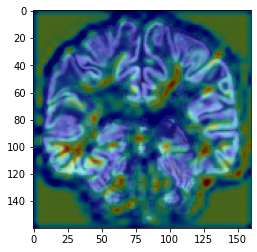

In [20]:
plt.imshow(np.rot90(brainsL[0,:,0,:]), cmap = "gray");
plt.imshow(np.rot90(heatmap_resize), cmap = "jet", alpha = 0.4)

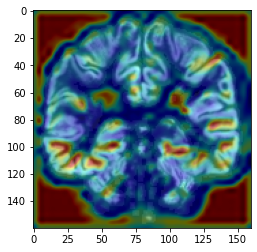

In [21]:
plt.imshow(np.rot90(brainsL[0,:,0,:]), cmap = "gray");
plt.imshow(np.rot90(heatmap_RTLE_resize), cmap = "jet", alpha = 0.4)

## Tests

Run 1 of 50
(378, 160, 160, 9) (80, 160, 160, 9) (82, 160, 160, 9)
Done loading slice
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 2 1 1 1 2
 1 2 1 1 1 0 1 1 1 2 0 1 1 1 1 1 1 1 1 1 1 2 2 2 2 1 0 2 1 2 0 1 2 1 1 2 1
 2 2 1 2 1 2 0 2]
Validation accuarcy: 81.250
Test accuarcy: 78.049
Run 2 of 50
(378, 160, 160, 9) (80, 160, 160, 9) (82, 160, 160, 9)
Done loading slice
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2]
[0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 2 1 1 1 1
 1 2 1 1 1 1 0 2 1 1 2 2 1 1 1 1 1 1 1 1 2 1 2 1 2 0 2 2 2 2 2 2 1 2 2 2 0
 2 0 2 2 2 2 2 2]
Validation accuarcy: 85.000
Test accuarcy: 82.927
Run 3 of 50
(378, 160, 160, 9) (80, 160, 160, 9) (82, 16

(378, 160, 160, 9) (80, 160, 160, 9) (82, 160, 160, 9)
Done loading slice
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2]
[0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 2 1 2 1 2 2 2
 1 1 1 1 0 2 2 2 2 2 1 1 2 1 2 1 1 0 2 1 2 2 2 0 2 2 2 2 2 2 2 2 2 2 0 2 2
 0 2 2 2 2 2 2 2]
Validation accuarcy: 86.250
Test accuarcy: 73.171
Run 20 of 50
(378, 160, 160, 9) (80, 160, 160, 9) (82, 160, 160, 9)
Done loading slice
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2]
[0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 2 1 1 2 1 1 1
 1 1 0 1 1 1 2 2 2 1 2 2 1 1 2 2 1 1 2 1 2 1 2 2 2 1 2 2 1 2 2 2 2 1 1 2 2
 1 2 1 2 1 2 2 1]
Validation accuarcy: 91.250
Test accuarcy: 73.171
Run 21 of 50
(378, 160, 160, 9) (80, 160, 160, 9) (82, 160, 160, 9)

(378, 160, 160, 9) (80, 160, 160, 9) (82, 160, 160, 9)
Done loading slice
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 2 1 0 1 1
 1 2 0 2 2 1 1 1 1 2 1 1 1 1 1 1 2 1 2 2 2 1 2 2 2 2 2 2 0 2 2 1 2 2 1 2 2
 2 1 2 1 1 2 1 2]
Validation accuarcy: 86.250
Test accuarcy: 78.049
Run 38 of 50
(378, 160, 160, 9) (80, 160, 160, 9) (82, 160, 160, 9)
Done loading slice
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 2 1 1 1 0 1 1 2 1 2 1 2 1 0 2 2 0 1 1 1 2 2 1 0 1 2 1 1
 1 2 1 1 2 2 1 2]
Validation accuarcy: 85.000
Test accuarcy: 76.829
Run 39 of 50
(378, 160, 160, 9) (80, 160, 160, 9) (82, 160, 160, 9)

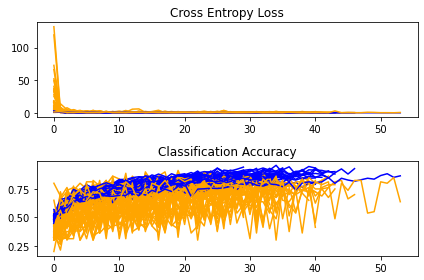

Val Accuracy: mean=83.750, std=4.093, n=50
Test Accuracy: mean=79.195, std=4.304, n=50


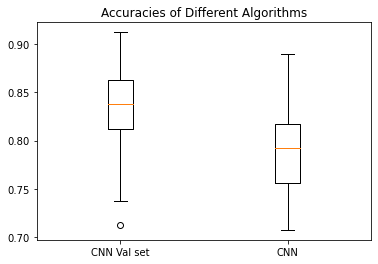

1367.232718706131


In [14]:
#Testing
start = time.time()
scores_val, scores_test = run_model(84, [0,1,2,3,4,5,6,7,8], 10, 'TESTING_C_L_R2')
end = time.time()
print(end-start)

Run 1 of 100
(263, 160, 160, 5) (56, 160, 160, 5) (57, 160, 160, 5)
Done loading slice
validation accuarcy: 94.643
Test accuarcy (val): 85.965
Test accuarcy (0.5): 85.965
Run 2 of 100
(263, 160, 160, 5) (56, 160, 160, 5) (57, 160, 160, 5)
Done loading slice
validation accuarcy: 96.429
Test accuarcy (val): 87.719
Test accuarcy (0.5): 87.719
Run 3 of 100
(263, 160, 160, 5) (56, 160, 160, 5) (57, 160, 160, 5)
Done loading slice
validation accuarcy: 92.857
Test accuarcy (val): 94.737
Test accuarcy (0.5): 94.737
Run 4 of 100
(263, 160, 160, 5) (56, 160, 160, 5) (57, 160, 160, 5)
Done loading slice
validation accuarcy: 98.214
Test accuarcy (val): 92.982
Test accuarcy (0.5): 92.982
Run 5 of 100
(263, 160, 160, 5) (56, 160, 160, 5) (57, 160, 160, 5)
Done loading slice
validation accuarcy: 100.000
Test accuarcy (val): 89.474
Test accuarcy (0.5): 91.228
Run 6 of 100
(263, 160, 160, 5) (56, 160, 160, 5) (57, 160, 160, 5)
Done loading slice
validation accuarcy: 96.429
Test accuarcy (val): 96.491
T

(263, 160, 160, 5) (56, 160, 160, 5) (57, 160, 160, 5)
Done loading slice
validation accuarcy: 98.214
Test accuarcy (val): 94.737
Test accuarcy (0.5): 94.737
Run 50 of 100
(263, 160, 160, 5) (56, 160, 160, 5) (57, 160, 160, 5)
Done loading slice
validation accuarcy: 92.857
Test accuarcy (val): 91.228
Test accuarcy (0.5): 91.228
Run 51 of 100
(263, 160, 160, 5) (56, 160, 160, 5) (57, 160, 160, 5)
Done loading slice
validation accuarcy: 98.214
Test accuarcy (val): 94.737
Test accuarcy (0.5): 94.737
Run 52 of 100
(263, 160, 160, 5) (56, 160, 160, 5) (57, 160, 160, 5)
Done loading slice
validation accuarcy: 94.643
Test accuarcy (val): 87.719
Test accuarcy (0.5): 87.719
Run 53 of 100
(263, 160, 160, 5) (56, 160, 160, 5) (57, 160, 160, 5)
Done loading slice
validation accuarcy: 91.071
Test accuarcy (val): 91.228
Test accuarcy (0.5): 91.228
Run 54 of 100
(263, 160, 160, 5) (56, 160, 160, 5) (57, 160, 160, 5)
Done loading slice
validation accuarcy: 96.429
Test accuarcy (val): 94.737
Test accua

(263, 160, 160, 5) (56, 160, 160, 5) (57, 160, 160, 5)
Done loading slice
validation accuarcy: 92.857
Test accuarcy (val): 94.737
Test accuarcy (0.5): 94.737
Run 98 of 100
(263, 160, 160, 5) (56, 160, 160, 5) (57, 160, 160, 5)
Done loading slice
validation accuarcy: 94.643
Test accuarcy (val): 94.737
Test accuarcy (0.5): 94.737
Run 99 of 100
(263, 160, 160, 5) (56, 160, 160, 5) (57, 160, 160, 5)
Done loading slice
validation accuarcy: 98.214
Test accuarcy (val): 92.982
Test accuarcy (0.5): 92.982
Run 100 of 100
(263, 160, 160, 5) (56, 160, 160, 5) (57, 160, 160, 5)
Done loading slice
validation accuarcy: 96.429
Test accuarcy (val): 92.982
Test accuarcy (0.5): 92.982
Done running model


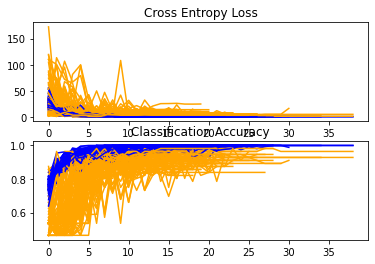

Val Accuracy (max): mean=94.893, std=3.052, n=100
Test Accuracy (val): mean=92.175, std=3.839, n=100
Test Accuracy (50): mean=92.088, std=4.081, n=100


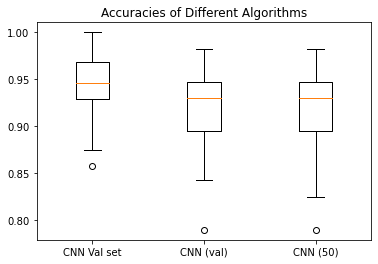

1217.368616104126


In [14]:
#Testing
start = time.time()
scores_val, scores_test = run_model(84, [0,1,2,3,4], 100, 'TESTING_CON')
end = time.time()
print(end-start)

In [ ]:
#Testing
start = time.time()
scores_val, scores_test = run_model(84, [1], 100, 'TESTING_CON2')
end = time.time()
print(end-start)

Run 1 of 100
(378, 160, 160, 9) (80, 160, 160, 9) (82, 160, 160, 9)
Done loading slice
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 2 1 2 1 1 2 1
 1 2 0 1 1 2 1 1 1 2 2 1 1 2 1 1 1 1 2 2 2 2 2 2 2 1 2 2 2 2 1 2 1 1 1 2 1
 2 1 2 2 2 1 2 2]
Validation accuarcy: 81.250
Test accuarcy: 75.610
Run 2 of 100
(378, 160, 160, 9) (80, 160, 160, 9) (82, 160, 160, 9)
Done loading slice
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2]
[0 0 0 0 0 0 0 2 0 0 1 0 0 0 0 0 1 0 0 0 0 2 0 2 0 0 0 1 2 1 2 1 0 1 1 1 1
 2 1 1 1 1 1 1 0 1 2 1 1 2 1 2 1 1 2 1 1 1 2 2 1 2 2 1 2 1 2 2 2 2 2 2 2 1
 1 2 2 2 1 2 1 2]
Validation accuarcy: 82.500
Test accuarcy: 73.171
Run 3 of 100
(378, 160, 160, 9) (80, 160, 160, 9) (82,

(378, 160, 160, 9) (80, 160, 160, 9) (82, 160, 160, 9)
Done loading slice
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2]
[0 0 0 0 0 0 0 0 0 0 2 0 2 0 0 0 0 0 0 0 0 1 0 0 0 2 0 1 1 2 1 2 1 1 1 1 1
 2 1 1 2 2 1 1 1 1 1 1 1 1 1 1 1 2 2 0 2 1 2 2 2 2 2 2 2 2 2 2 2 2 1 1 2 2
 2 2 1 0 1 2 2 2]
Validation accuarcy: 83.750
Test accuarcy: 76.829
Run 20 of 100
(378, 160, 160, 9) (80, 160, 160, 9) (82, 160, 160, 9)
Done loading slice
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2]
[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 2 1 1 2 1 1 1 1 1 1
 1 1 0 1 1 1 0 1 1 1 1 1 1 2 1 0 2 1 1 1 2 2 2 2 2 0 2 1 2 1 1 2 2 2 2 2 2
 2 2 2 1 2 2 2 2]
Validation accuarcy: 80.000
Test accuarcy: 82.927
Run 21 of 100
(378, 160, 160, 9) (80, 160, 160, 9) (82, 160, 160, 

(378, 160, 160, 9) (80, 160, 160, 9) (82, 160, 160, 9)
Done loading slice
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 2 1 1 2 0 1 1 2
 0 1 1 1 1 1 1 0 0 1 1 0 1 0 1 0 1 0 2 1 0 2 1 0 2 2 2 1 0 0 2 2 2 0 2 2 2
 2 2 1 1 0 2 2 0]
Validation accuarcy: 83.750
Test accuarcy: 71.951
Run 38 of 100
(378, 160, 160, 9) (80, 160, 160, 9) (82, 160, 160, 9)
Done loading slice
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 1 1 1 1 1 1 1 1 1
 1 1 1 1 2 1 1 1 1 1 1 1 2 1 2 0 2 1 1 1 2 2 2 1 1 0 2 2 2 2 2 2 2 2 2 2 1
 2 2 2 2 1 2 1 2]
Validation accuarcy: 87.500
Test accuarcy: 85.366
Run 39 of 100
(378, 160, 160, 9) (80, 160, 160, 9) (82, 160, 160, 

(378, 160, 160, 9) (80, 160, 160, 9) (82, 160, 160, 9)
Done loading slice
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 2 1 1 1 1 1 1 1 1 2
 1 1 1 1 2 1 1 1 2 0 1 1 1 1 1 1 1 1 1 1 2 2 1 2 2 1 1 0 1 1 0 2 2 1 2 2 2
 1 1 2 1 2 2 1 2]
Validation accuarcy: 83.750
Test accuarcy: 78.049
Run 56 of 100
(378, 160, 160, 9) (80, 160, 160, 9) (82, 160, 160, 9)
Done loading slice
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 2 1 1 0 1 0 1
 1 2 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 1 2 1 1 2 1 2 2 2 1 0 1 1
 2 1 1 2 2 2 1 1]
Validation accuarcy: 88.750
Test accuarcy: 78.049
Run 57 of 100
(378, 160, 160, 9) (80, 160, 160, 9) (82, 160, 160, 

(378, 160, 160, 9) (80, 160, 160, 9) (82, 160, 160, 9)
Done loading slice
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1 1 1 0 1 1 2 2 1 2
 1 1 1 1 2 1 1 1 1 2 1 1 1 1 1 1 1 1 2 1 2 1 2 2 2 2 2 2 1 2 2 2 2 2 1 2 2
 0 2 2 2 1 2 2 2]
Validation accuarcy: 85.000
Test accuarcy: 82.927
Run 74 of 100
(378, 160, 160, 9) (80, 160, 160, 9) (82, 160, 160, 9)
Done loading slice
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2]
[2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 1 1 2 2 1 1 1 1 1 2
 1 1 1 1 1 2 1 2 1 1 1 1 2 1 0 1 1 2 1 1 2 1 1 1 1 2 2 2 2 1 1 2 1 2 1 2 2
 2 2 2 2 1 2 2 2]
Validation accuarcy: 78.750
Test accuarcy: 76.829
Run 75 of 100
(378, 160, 160, 9) (80, 160, 160, 9) (82, 160, 160, 

(378, 160, 160, 9) (80, 160, 160, 9) (82, 160, 160, 9)
Done loading slice
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 1 1 1 1 1
 1 1 1 1 1 1 2 1 1 2 2 1 1 1 1 1 1 1 1 1 1 2 1 1 1 2 2 0 2 1 2 2 1 0 2 1 2
 2 1 2 2 2 2 2 2]
Validation accuarcy: 85.000
Test accuarcy: 81.707
Run 92 of 100
(378, 160, 160, 9) (80, 160, 160, 9) (82, 160, 160, 9)
Done loading slice
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 1 0 1 1 1
 1 1 1 1 0 1 1 1 0 1 1 0 1 2 0 0 1 1 0 1 1 1 2 2 1 2 2 1 2 2 2 2 2 2 2 1 0
 2 2 2 2 0 2 0 2]
Validation accuarcy: 88.750
Test accuarcy: 75.610
Run 93 of 100
(378, 160, 160, 9) (80, 160, 160, 9) (82, 160, 160, 

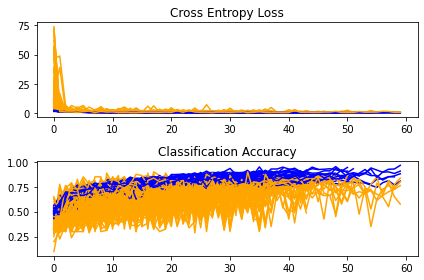

Val Accuracy: mean=82.525, std=3.845, n=100
Test Accuracy: mean=78.110, std=4.452, n=100


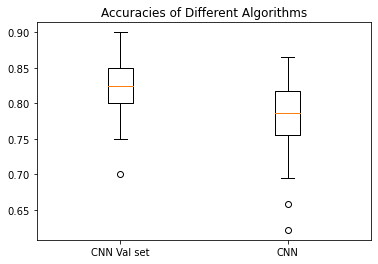

3584.2962925434113


In [13]:
#Testing
start = time.time()
scores_val, scores_test = run_model(84, [0,1,2,3,4,5,6,7,8], 100, 'TESTING_C_L_R')
end = time.time()
print(end-start)

Running slice: 78
Run 1 of 10
(378, 160, 160, 1) (80, 160, 160, 1) (82, 160, 160, 1)
Done loading slice
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2]
[0 0 1 1 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 1 0 2 1 1 1 1 1 1 1 0 1
 1 1 1 1 1 1 0 1 1 2 1 2 1 1 1 2 2 1 0 1 1 2 1 1 1 1 1 2 2 1 2 1 1 2 0 1 1
 2 1 1 1 1 2 1 1]
Validation accuarcy: 65.000
Test accuarcy: 58.537
Run 2 of 10
(378, 160, 160, 1) (80, 160, 160, 1) (82, 160, 160, 1)
Done loading slice
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 2 2 1 0 1 1
 0 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 0 1 1 2 0 2 0 2 2 1 1 1 1 1 1 2 0 2 1 1
 1 1 1 1 1 1 1 1]
Validation accuarcy: 68.750
Test accuarcy: 67.073
Run 3 of 10
(378, 160, 160, 1) (80, 16

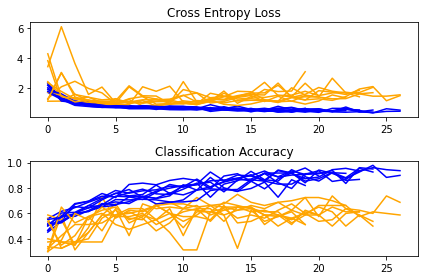

Val Accuracy: mean=68.500, std=3.657, n=10
Test Accuracy: mean=62.683, std=4.404, n=10
dict_values([array([0.64999998, 0.6875    , 0.72500002, 0.75      , 0.67500001,
       0.73750001, 0.66250002, 0.64999998, 0.66250002, 0.64999998]), array([0.58536583, 0.67073172, 0.67073172, 0.70731705, 0.63414633,
       0.57317072, 0.597561  , 0.64634144, 0.57317072, 0.60975611])])


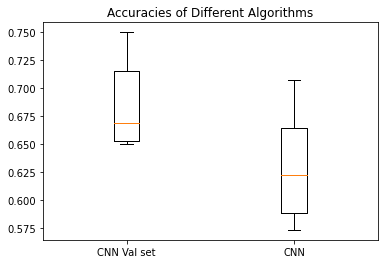

147.75696730613708
Running slice: 79
Run 1 of 10
(378, 160, 160, 1) (80, 160, 160, 1) (82, 160, 160, 1)
Done loading slice
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2]
[0 0 1 0 0 0 0 0 1 0 0 2 0 1 0 0 0 0 1 1 0 1 1 0 0 1 0 1 1 1 1 1 0 1 0 2 1
 2 1 1 1 1 2 2 1 1 1 1 2 1 1 1 2 2 2 1 1 2 1 1 1 1 2 2 1 1 2 1 2 2 2 1 1 1
 1 2 2 2 2 2 1 2]
Validation accuarcy: 82.500
Test accuarcy: 62.195
Run 2 of 10
(378, 160, 160, 1) (80, 160, 160, 1) (82, 160, 160, 1)
Done loading slice
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2]
[0 0 1 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 1 1 1 0 0 0 0 1 0 1 1 1 2 1 1 1 1 1 2
 1 2 0 2 2 2 1 1 1 1 1 1 1 1 1 2 1 1 2 1 2 1 1 1 2 2 1 2 1 2 1 1 2 1 1 1 1
 1 1 2 1 1 1 1 1]
Validation accuarcy: 73.750
Test accuarcy: 57.317
Run 3 of 10
(378, 1

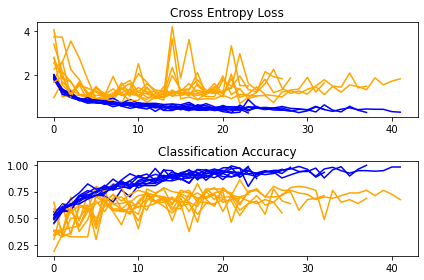

Val Accuracy: mean=77.500, std=4.402, n=10
Test Accuracy: mean=65.366, std=4.945, n=10
dict_values([array([0.82499999, 0.73750001, 0.80000001, 0.71249998, 0.86250001,
       0.77499998, 0.78750002, 0.75      , 0.77499998, 0.72500002]), array([0.62195122, 0.57317072, 0.62195122, 0.65853661, 0.62195122,
       0.73170733, 0.69512194, 0.71951222, 0.60975611, 0.68292683])])


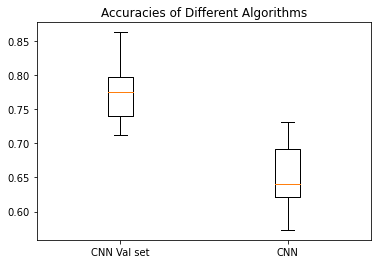

153.78789806365967
Running slice: 80
Run 1 of 10
(378, 160, 160, 1) (80, 160, 160, 1) (82, 160, 160, 1)
Done loading slice
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 1 1 1 1 1 1 1 0
 1 1 1 1 1 0 1 1 0 2 0 1 1 0 2 0 1 1 1 0 2 1 1 1 2 2 1 1 2 2 2 2 2 2 2 2 2
 1 1 1 1 1 1 2 2]
Validation accuarcy: 73.750
Test accuarcy: 74.390
Run 2 of 10
(378, 160, 160, 1) (80, 160, 160, 1) (82, 160, 160, 1)
Done loading slice
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2]
[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 1 1 2 1 1 0 1 1
 1 2 1 1 1 0 1 1 2 1 1 1 1 1 1 1 2 1 2 1 0 2 2 2 1 2 1 2 0 1 2 2 1 1 2 2 1
 2 2 1 2 1 1 2 2]
Validation accuarcy: 80.000
Test accuarcy: 75.610
Run 3 of 10
(378, 1

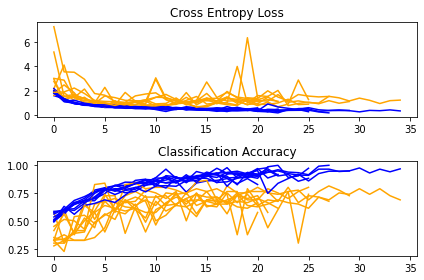

Val Accuracy: mean=77.250, std=5.117, n=10
Test Accuracy: mean=73.049, std=4.861, n=10
dict_values([array([0.73750001, 0.80000001, 0.6875    , 0.76249999, 0.80000001,
       0.86250001, 0.8125    , 0.73750001, 0.71249998, 0.8125    ]), array([0.74390244, 0.75609756, 0.78048778, 0.65853661, 0.63414633,
       0.80487806, 0.73170733, 0.73170733, 0.71951222, 0.74390244])])


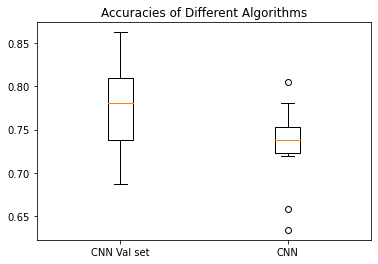

144.072327375412
Running slice: 81
Run 1 of 10
(378, 160, 160, 1) (80, 160, 160, 1) (82, 160, 160, 1)
Done loading slice
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2]
[0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 2 2 0 1 1 0 0 0 0 2 0 1 1 1 2 2 1 1 1 1 1
 1 1 1 1 0 1 0 2 1 1 2 1 1 1 1 1 1 1 1 2 2 1 1 1 2 2 1 2 2 1 1 1 1 2 1 1 1
 2 1 1 1 2 2 1 1]
Validation accuarcy: 81.250
Test accuarcy: 63.415
Run 2 of 10
(378, 160, 160, 1) (80, 160, 160, 1) (82, 160, 160, 1)
Done loading slice
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2]
[0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 2 1 1 1 1 1 0 2 1 1
 2 1 1 1 1 2 1 2 1 2 2 1 2 1 1 1 1 1 2 0 1 1 2 2 1 2 2 2 2 0 2 2 2 2 2 2 1
 1 2 2 2 2 1 1 2]
Validation accuarcy: 80.000
Test accuarcy: 71.951
Run 3 of 10
(378, 160

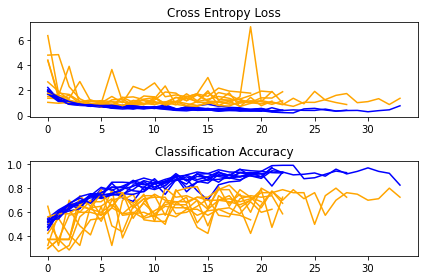

Val Accuracy: mean=76.625, std=5.033, n=10
Test Accuracy: mean=70.244, std=5.803, n=10
dict_values([array([0.8125    , 0.80000001, 0.66250002, 0.80000001, 0.76249999,
       0.71249998, 0.71249998, 0.82499999, 0.78750002, 0.78750002]), array([0.63414633, 0.71951222, 0.67073172, 0.73170733, 0.68292683,
       0.70731705, 0.58536583, 0.74390244, 0.79268295, 0.75609756])])


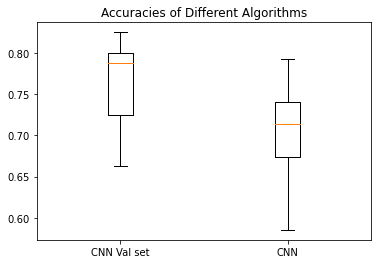

139.56958532333374
Running slice: 82
Run 1 of 10
(378, 160, 160, 1) (80, 160, 160, 1) (82, 160, 160, 1)
Done loading slice
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 1 0 1 1 1
 1 1 1 1 1 1 1 0 2 1 1 1 1 0 1 1 1 1 1 2 1 1 2 2 2 2 2 1 2 2 1 2 2 1 1 2 2
 0 0 0 1 1 1 2 1]
Validation accuarcy: 75.000
Test accuarcy: 75.610
Run 2 of 10
(378, 160, 160, 1) (80, 160, 160, 1) (82, 160, 160, 1)
Done loading slice
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 1 1 1 1 0
 1 1 1 1 2 2 0 1 2 1 2 0 1 1 2 1 1 0 0 1 2 2 2 2 2 0 2 2 1 2 1 1 1 1 2 2 1
 1 2 2 2 2 2 0 0]
Validation accuarcy: 77.500
Test accuarcy: 73.171
Run 3 of 10
(378, 1

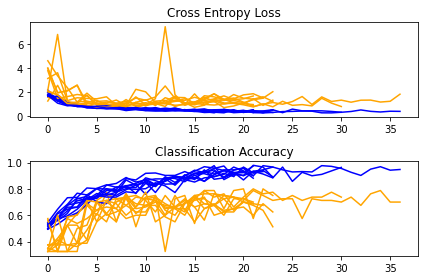

Val Accuracy: mean=76.500, std=2.550, n=10
Test Accuracy: mean=72.317, std=2.888, n=10
dict_values([array([0.75      , 0.77499998, 0.76249999, 0.80000001, 0.80000001,
       0.73750001, 0.72500002, 0.73750001, 0.77499998, 0.78750002]), array([0.75609756, 0.73170733, 0.71951222, 0.75609756, 0.70731705,
       0.73170733, 0.75609756, 0.65853661, 0.70731705, 0.70731705])])


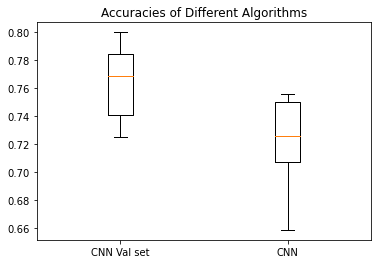

143.69170093536377
Running slice: 83
Run 1 of 10
(378, 160, 160, 1) (80, 160, 160, 1) (82, 160, 160, 1)
Done loading slice
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 1 1 2 1 2
 1 2 1 1 2 2 2 1 1 2 1 1 0 2 0 2 2 2 2 0 2 2 0 2 2 2 2 2 2 2 2 2 2 2 2 1 2
 2 2 2 2 0 2 2 0]
Validation accuarcy: 75.000
Test accuarcy: 71.951
Run 2 of 10
(378, 160, 160, 1) (80, 160, 160, 1) (82, 160, 160, 1)
Done loading slice
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2]
[0 0 0 0 0 2 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 2 1 1 2 0 2 2 2 1 2
 2 1 1 1 1 1 1 1 1 1 0 0 2 2 1 0 2 2 1 2 2 1 2 1 2 2 0 1 2 1 2 2 2 2 1 2 0
 1 2 2 2 2 2 0 2]
Validation accuarcy: 77.500
Test accuarcy: 65.854
Run 3 of 10
(378, 1

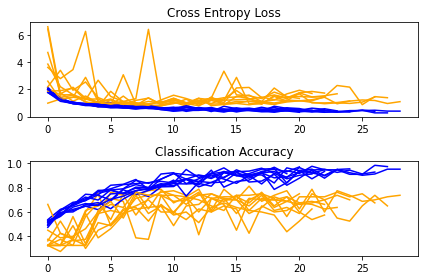

Val Accuracy: mean=75.500, std=3.841, n=10
Test Accuracy: mean=69.634, std=6.229, n=10
dict_values([array([0.75      , 0.77499998, 0.78750002, 0.77499998, 0.75      ,
       0.69999999, 0.8125    , 0.76249999, 0.76249999, 0.67500001]), array([0.71951222, 0.65853661, 0.81707317, 0.67073172, 0.69512194,
       0.65853661, 0.78048778, 0.67073172, 0.70731705, 0.58536583])])


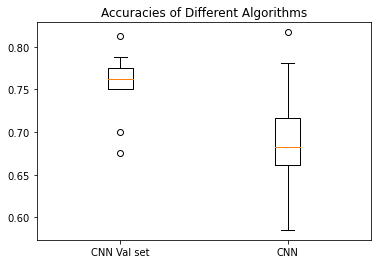

142.98567962646484
Running slice: 84
Run 1 of 10
(378, 160, 160, 1) (80, 160, 160, 1) (82, 160, 160, 1)
Done loading slice
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2]
[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 1 2 1 2 2 2 1
 1 1 1 2 1 1 1 2 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 1 0 1 1 1 2 2 1 2 2
 2 0 2 2 1 1 2 2]
Validation accuarcy: 76.250
Test accuarcy: 73.171
Run 2 of 10
(378, 160, 160, 1) (80, 160, 160, 1) (82, 160, 160, 1)
Done loading slice
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 1 2 2 1 1 1 1 1 1
 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 0 2 1 2 1 1 2 2 2 2 2 1 2 2 1 1 1 0 2
 1 1 2 2 2 1 2 2]
Validation accuarcy: 78.750
Test accuarcy: 76.829
Run 3 of 10
(378, 1

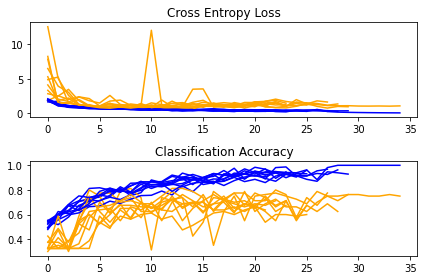

Val Accuracy: mean=76.625, std=4.148, n=10
Test Accuracy: mean=73.659, std=6.127, n=10
dict_values([array([0.76249999, 0.78750002, 0.8125    , 0.66250002, 0.8125    ,
       0.76249999, 0.80000001, 0.75      , 0.75      , 0.76249999]), array([0.73170733, 0.76829267, 0.81707317, 0.63414633, 0.71951222,
       0.67073172, 0.65853661, 0.76829267, 0.79268295, 0.80487806])])


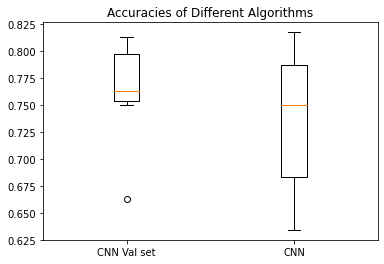

153.4493088722229
Running slice: 85
Run 1 of 10
(378, 160, 160, 1) (80, 160, 160, 1) (82, 160, 160, 1)
Done loading slice
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 1 1 0 1 1 1
 1 1 1 2 2 2 0 2 1 1 1 2 2 0 0 1 1 2 1 0 0 0 2 2 1 1 2 2 1 2 2 2 1 2 2 1 1
 0 0 2 1 1 1 2 1]
Validation accuarcy: 81.250
Test accuarcy: 67.073
Run 2 of 10
(378, 160, 160, 1) (80, 160, 160, 1) (82, 160, 160, 1)
Done loading slice
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2]
[0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 1 0 0 2 0 0 0 2 2 2 0 1 2
 1 1 1 1 1 1 1 2 1 1 1 2 1 0 1 1 1 0 1 1 1 2 2 2 2 2 2 0 2 2 1 2 1 2 2 1 2
 2 2 0 2 1 2 1 2]
Validation accuarcy: 77.500
Test accuarcy: 70.732
Run 3 of 10
(378, 16

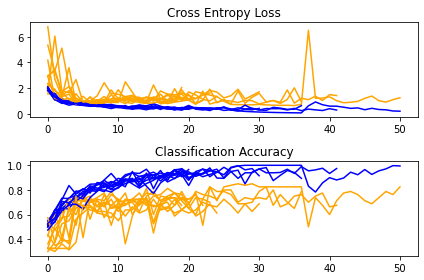

Val Accuracy: mean=78.375, std=3.834, n=10
Test Accuracy: mean=71.707, std=4.356, n=10
dict_values([array([0.8125    , 0.77499998, 0.78750002, 0.85000002, 0.76249999,
       0.72500002, 0.80000001, 0.82499999, 0.77499998, 0.72500002]), array([0.67073172, 0.70731705, 0.73170733, 0.69512194, 0.74390244,
       0.65853661, 0.78048778, 0.79268295, 0.71951222, 0.67073172])])


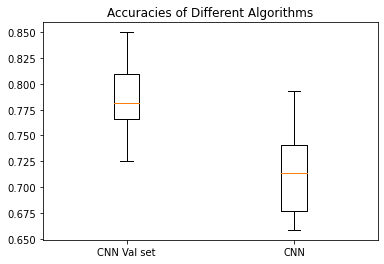

167.27383494377136
Running slice: 86
Run 1 of 10
(378, 160, 160, 1) (80, 160, 160, 1) (82, 160, 160, 1)
Done loading slice
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2]
[0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 1 1 1 1 1 1 1 1 2 1
 1 1 2 1 1 2 2 2 1 2 2 1 1 2 1 2 2 1 1 1 2 1 2 2 2 2 2 2 2 2 1 1 2 2 2 1 2
 2 2 2 0 2 2 2 2]
Validation accuarcy: 78.750
Test accuarcy: 79.268
Run 2 of 10
(378, 160, 160, 1) (80, 160, 160, 1) (82, 160, 160, 1)
Done loading slice
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 2 2 1 1 2 1 1 1 0 1
 2 2 1 0 2 2 2 1 2 2 2 0 0 2 2 2 0 0 2 2 2 1 2 2 2 0 1 2 2 2 1 2 2 2 2 2 2
 2 2 0 1 0 1 1 2]
Validation accuarcy: 77.500
Test accuarcy: 60.976
Run 3 of 10
(378, 1

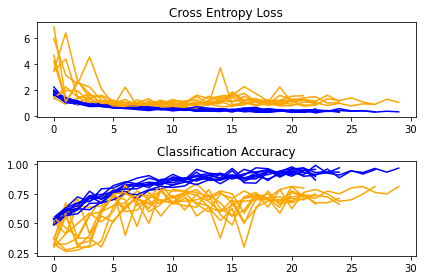

Val Accuracy: mean=78.875, std=2.649, n=10
Test Accuracy: mean=72.927, std=6.044, n=10
dict_values([array([0.78750002, 0.77499998, 0.78750002, 0.77499998, 0.75      ,
       0.77499998, 0.82499999, 0.8125    , 0.83749998, 0.76249999]), array([0.79268295, 0.60975611, 0.76829267, 0.81707317, 0.71951222,
       0.70731705, 0.70731705, 0.70731705, 0.67073172, 0.79268295])])


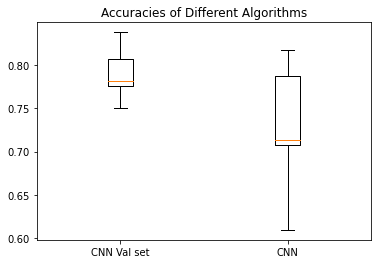

148.08926057815552
Running slice: 87
Run 1 of 10
(378, 160, 160, 1) (80, 160, 160, 1) (82, 160, 160, 1)
Done loading slice
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2]
[1 0 1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 2 0 0 2 1 1 1 1 1 2 2 1 2 2
 2 2 1 1 1 1 1 1 2 1 1 2 1 1 2 1 1 1 1 2 2 2 2 2 1 2 1 2 2 2 1 2 2 2 2 1 2
 1 2 0 2 2 2 1 1]
Validation accuarcy: 81.250
Test accuarcy: 69.512
Run 2 of 10
(378, 160, 160, 1) (80, 160, 160, 1) (82, 160, 160, 1)
Done loading slice
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2]
[0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 2 1 1 1 0 1 1
 1 2 1 1 1 2 2 1 2 1 2 1 1 1 1 2 1 1 1 1 2 0 2 2 1 2 1 0 2 1 1 1 2 2 1 2 2
 1 0 0 2 2 2 1 2]
Validation accuarcy: 78.750
Test accuarcy: 73.171
Run 3 of 10
(378, 1

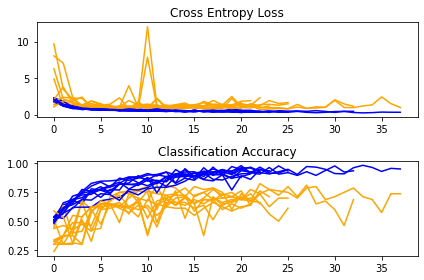

Val Accuracy: mean=75.125, std=5.228, n=10
Test Accuracy: mean=69.878, std=3.897, n=10
dict_values([array([0.8125    , 0.78750002, 0.82499999, 0.73750001, 0.8125    ,
       0.66250002, 0.73750001, 0.69999999, 0.71249998, 0.72500002]), array([0.69512194, 0.73170733, 0.75609756, 0.67073172, 0.69512194,
       0.60975611, 0.69512194, 0.69512194, 0.74390244, 0.69512194])])


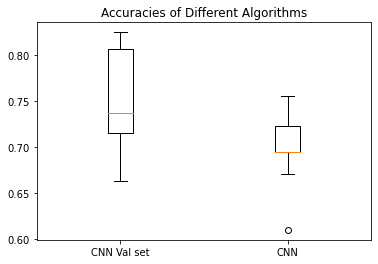

159.74353623390198
Running slice: 88
Run 1 of 10
(378, 160, 160, 1) (80, 160, 160, 1) (82, 160, 160, 1)
Done loading slice
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2]
[0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 1 2 1 1 1 1 2 2 2 0
 1 2 1 1 2 1 2 1 1 2 1 1 1 1 1 1 1 2 1 0 2 1 2 1 2 2 2 2 1 1 2 1 1 1 2 1 2
 2 2 1 1 2 2 2 2]
Validation accuarcy: 81.250
Test accuarcy: 70.732
Run 2 of 10
(378, 160, 160, 1) (80, 160, 160, 1) (82, 160, 160, 1)
Done loading slice
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 2 2 0 1 1 1
 1 2 1 2 1 2 0 0 2 2 2 2 1 1 0 1 2 1 2 1 2 2 1 1 0 2 2 2 2 2 2 0 1 2 0 2 1
 2 2 1 2 2 2 1 1]
Validation accuarcy: 73.750
Test accuarcy: 64.634
Run 3 of 10
(378, 1

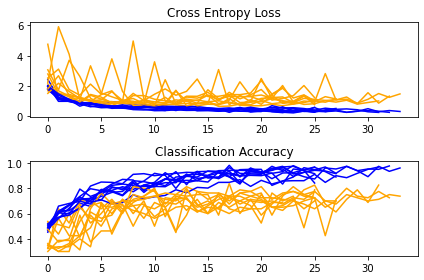

Val Accuracy: mean=78.250, std=4.514, n=10
Test Accuracy: mean=70.732, std=5.116, n=10
dict_values([array([0.8125    , 0.73750001, 0.82499999, 0.77499998, 0.6875    ,
       0.80000001, 0.8125    , 0.80000001, 0.73750001, 0.83749998]), array([0.70731705, 0.64634144, 0.74390244, 0.70731705, 0.68292683,
       0.60975611, 0.70731705, 0.70731705, 0.76829267, 0.79268295])])


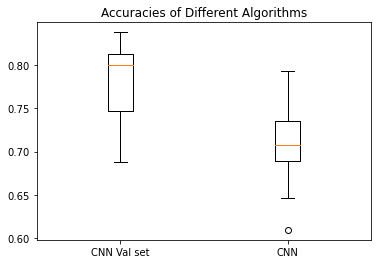

169.6257517337799
Running slice: 89
Run 1 of 10
(378, 160, 160, 1) (80, 160, 160, 1) (82, 160, 160, 1)
Done loading slice
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2]
[0 0 0 0 0 0 0 2 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 2 2 2 1 2 2
 1 1 2 0 2 2 1 1 0 2 2 1 1 2 1 1 1 1 1 2 2 1 2 2 2 1 2 2 2 2 2 1 2 1 2 2 2
 2 2 1 2 2 2 2 2]
Validation accuarcy: 73.750
Test accuarcy: 70.732
Run 2 of 10
(378, 160, 160, 1) (80, 160, 160, 1) (82, 160, 160, 1)
Done loading slice
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2]
[0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 1 1 1 1 1 1 2 1 1
 1 2 0 1 1 1 1 1 1 2 1 0 1 0 1 1 1 2 1 1 2 2 2 2 1 0 1 1 1 2 2 2 2 1 1 2 1
 1 2 1 2 0 2 1 2]
Validation accuarcy: 76.250
Test accuarcy: 73.171
Run 3 of 10
(378, 16

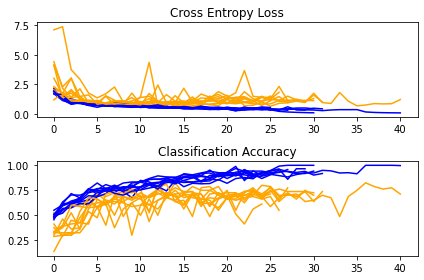

Val Accuracy: mean=76.875, std=3.676, n=10
Test Accuracy: mean=69.268, std=8.463, n=10
dict_values([array([0.73750001, 0.76249999, 0.77499998, 0.82499999, 0.82499999,
       0.73750001, 0.8125    , 0.72500002, 0.73750001, 0.75      ]), array([0.70731705, 0.73170733, 0.75609756, 0.73170733, 0.73170733,
       0.68292683, 0.80487806, 0.70731705, 0.56097561, 0.51219511])])


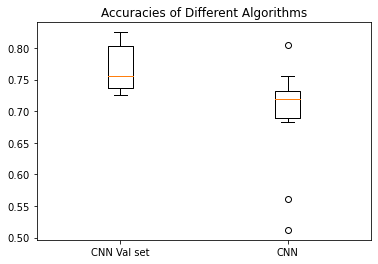

180.62050199508667
Running slice: 90
Run 1 of 10
(378, 160, 160, 1) (80, 160, 160, 1) (82, 160, 160, 1)
Done loading slice
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2]
[0 0 1 1 1 0 1 1 0 0 2 1 0 0 0 1 0 0 0 0 0 1 1 1 0 0 0 2 1 2 1 2 2 1 1 1 1
 1 2 1 2 1 1 1 1 2 2 2 1 1 1 2 2 2 2 1 2 1 1 2 1 0 1 2 2 2 2 1 2 2 2 2 1 2
 1 1 2 1 2 2 2 1]
Validation accuarcy: 73.750
Test accuarcy: 56.098
Run 2 of 10
(378, 160, 160, 1) (80, 160, 160, 1) (82, 160, 160, 1)
Done loading slice
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 2 2 1 2 2 2 2
 1 0 2 1 1 2 0 2 1 1 1 2 2 2 1 1 2 2 1 2 1 2 0 2 2 1 1 2 2 2 2 2 2 2 1 2 2
 1 2 1 1 1 2 2 2]
Validation accuarcy: 77.500
Test accuarcy: 65.854
Run 3 of 10
(378, 1

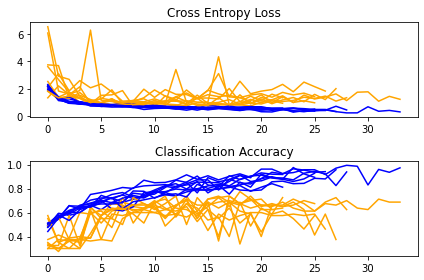

Val Accuracy: mean=71.375, std=4.523, n=10
Test Accuracy: mean=66.951, std=5.012, n=10
dict_values([array([0.73750001, 0.77499998, 0.72500002, 0.73750001, 0.71249998,
       0.61250001, 0.73750001, 0.73750001, 0.71249998, 0.64999998]), array([0.56097561, 0.65853661, 0.70731705, 0.74390244, 0.71951222,
       0.62195122, 0.69512194, 0.64634144, 0.65853661, 0.68292683])])


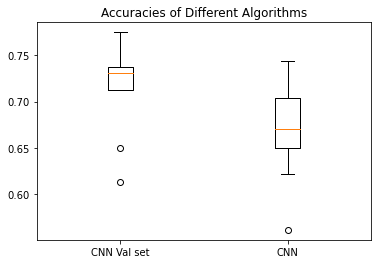

170.06515073776245
Running slice: 91
Run 1 of 10
(378, 160, 160, 1) (80, 160, 160, 1) (82, 160, 160, 1)
Done loading slice
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 1 1 1 2 1
 1 1 1 1 1 1 1 1 1 1 1 2 1 2 1 1 1 1 0 1 2 1 1 2 2 2 2 2 2 1 2 1 2 0 1 1 1
 1 1 1 1 1 1 2 2]
Validation accuarcy: 76.250
Test accuarcy: 76.829
Run 2 of 10
(378, 160, 160, 1) (80, 160, 160, 1) (82, 160, 160, 1)
Done loading slice
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2]
[0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 1 1 1 1 1 1 2 1 1
 0 1 1 1 1 1 1 1 1 1 1 0 1 2 1 1 1 2 1 1 1 1 1 2 2 1 1 1 1 0 2 2 2 1 2 2 1
 2 2 1 1 1 2 1 2]
Validation accuarcy: 73.750
Test accuarcy: 74.390
Run 3 of 10
(378, 1

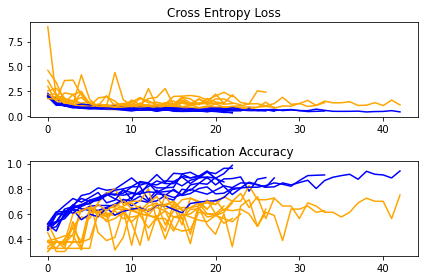

Val Accuracy: mean=71.500, std=4.867, n=10
Test Accuracy: mean=66.463, std=6.550, n=10
dict_values([array([0.76249999, 0.73750001, 0.71249998, 0.64999998, 0.71249998,
       0.82499999, 0.71249998, 0.66250002, 0.69999999, 0.67500001]), array([0.76829267, 0.74390244, 0.68292683, 0.73170733, 0.56097561,
       0.68292683, 0.63414633, 0.62195122, 0.63414633, 0.58536583])])


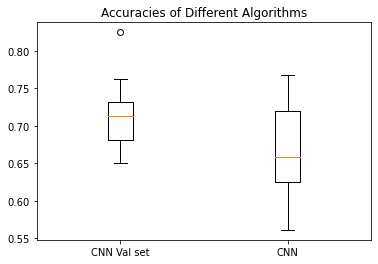

178.77609872817993
Running slice: 92
Run 1 of 10
(378, 160, 160, 1) (80, 160, 160, 1) (82, 160, 160, 1)
Done loading slice
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 1 1 1 1 1 1 1 1
 1 1 0 0 1 2 1 1 1 1 1 0 2 1 2 1 2 1 1 1 1 0 1 2 1 1 1 1 2 1 1 1 2 2 1 2 2
 1 2 1 1 1 2 1 1]
Validation accuarcy: 68.750
Test accuarcy: 69.512
Run 2 of 10
(378, 160, 160, 1) (80, 160, 160, 1) (82, 160, 160, 1)
Done loading slice
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2]
[0 0 1 0 1 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 2 2 0 2 1 2
 1 1 1 1 1 1 2 1 2 1 1 1 1 2 1 1 1 1 2 1 1 1 1 1 2 0 2 1 1 2 1 2 2 2 1 0 2
 1 0 1 1 2 2 1 1]
Validation accuarcy: 66.250
Test accuarcy: 63.415
Run 3 of 10
(378, 1

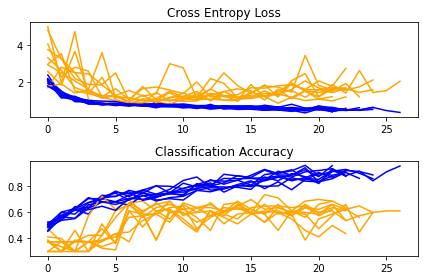

Val Accuracy: mean=67.750, std=2.839, n=10
Test Accuracy: mean=65.976, std=4.642, n=10
dict_values([array([0.6875    , 0.66250002, 0.66250002, 0.66250002, 0.6875    ,
       0.69999999, 0.73750001, 0.6875    , 0.625     , 0.66250002]), array([0.69512194, 0.63414633, 0.70731705, 0.68292683, 0.64634144,
       0.597561  , 0.60975611, 0.69512194, 0.73170733, 0.597561  ])])


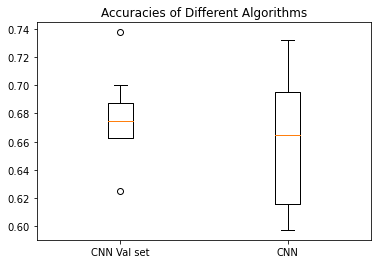

179.39972949028015
Running slice: 93
Run 1 of 10
(378, 160, 160, 1) (80, 160, 160, 1) (82, 160, 160, 1)
Done loading slice
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2]
[0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 2 1 1 1 2 1 1 2
 1 1 1 1 2 1 2 1 1 2 1 2 1 1 0 0 2 2 0 1 2 2 2 1 1 2 2 1 2 1 1 1 2 2 1 2 1
 1 2 2 2 2 1 1 1]
Validation accuarcy: 67.500
Test accuarcy: 65.854
Run 2 of 10
(378, 160, 160, 1) (80, 160, 160, 1) (82, 160, 160, 1)
Done loading slice
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 1 0 1 1 1 1 1 2
 2 1 2 0 1 1 1 0 1 2 1 1 0 2 0 1 0 1 1 1 2 0 1 1 2 1 1 1 1 1 1 1 1 2 1 1 0
 1 1 0 0 1 2 2 2]
Validation accuarcy: 73.750
Test accuarcy: 60.976
Run 3 of 10
(378, 1

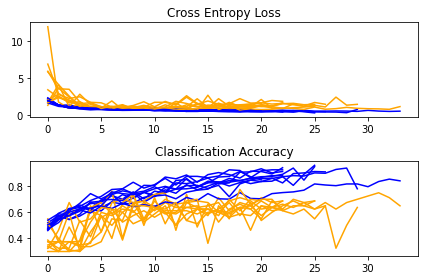

Val Accuracy: mean=71.500, std=3.700, n=10
Test Accuracy: mean=64.878, std=5.530, n=10
dict_values([array([0.67500001, 0.73750001, 0.64999998, 0.71249998, 0.76249999,
       0.73750001, 0.71249998, 0.77499998, 0.6875    , 0.69999999]), array([0.65853661, 0.60975611, 0.52439022, 0.68292683, 0.68292683,
       0.68292683, 0.63414633, 0.74390244, 0.62195122, 0.64634144])])


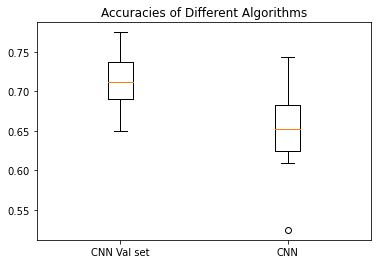

198.27813410758972
Running slice: 94
Run 1 of 10
(378, 160, 160, 1) (80, 160, 160, 1) (82, 160, 160, 1)
Done loading slice
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 2 0 2 2 2 0
 1 2 1 2 2 2 1 1 2 1 2 2 0 1 2 1 0 2 1 0 2 2 2 2 0 1 2 2 2 2 2 2 2 2 0 0 2
 1 1 0 2 1 1 0 2]
Validation accuarcy: 67.500
Test accuarcy: 60.976
Run 2 of 10
(378, 160, 160, 1) (80, 160, 160, 1) (82, 160, 160, 1)
Done loading slice
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 2 0 0 1 0 0 1
 2 2 1 2 0 1 1 1 2 0 1 1 1 0 1 2 0 0 1 1 1 1 1 1 2 0 1 1 1 1 0 2 2 1 2 2 1
 1 1 1 2 2 2 1 0]
Validation accuarcy: 62.500
Test accuarcy: 60.976
Run 3 of 10
(378, 1

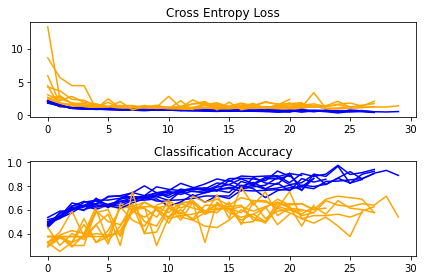

Val Accuracy: mean=68.625, std=4.692, n=10
Test Accuracy: mean=64.756, std=4.412, n=10
dict_values([array([0.67500001, 0.625     , 0.66250002, 0.66250002, 0.67500001,
       0.64999998, 0.66250002, 0.71249998, 0.75      , 0.78750002]), array([0.60975611, 0.60975611, 0.68292683, 0.64634144, 0.68292683,
       0.58536583, 0.70731705, 0.69512194, 0.58536583, 0.67073172])])


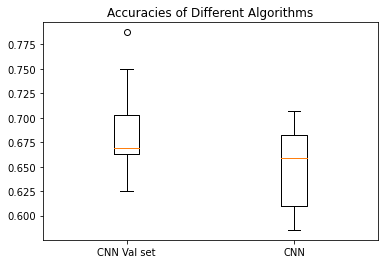

202.76995134353638
Running slice: 95
Run 1 of 10
(378, 160, 160, 1) (80, 160, 160, 1) (82, 160, 160, 1)
Done loading slice
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2]
[0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 1 0 0 1 0 2 1 1 1 1 2 1 1 1 2
 1 0 1 1 0 2 0 0 2 1 1 2 1 1 2 2 1 2 2 1 2 1 2 1 2 1 2 1 2 1 2 1 2 2 1 1 1
 1 0 1 2 2 1 1 1]
Validation accuarcy: 76.250
Test accuarcy: 58.537
Run 2 of 10
(378, 160, 160, 1) (80, 160, 160, 1) (82, 160, 160, 1)
Done loading slice
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 1 2 1 1 1 1 1 1 1
 2 1 2 1 2 1 1 2 1 1 1 1 1 0 2 1 1 1 0 0 0 1 2 2 2 2 1 1 0 1 2 0 1 1 2 1 2
 0 2 1 1 2 1 2 2]
Validation accuarcy: 78.750
Test accuarcy: 70.732
Run 3 of 10
(378, 1

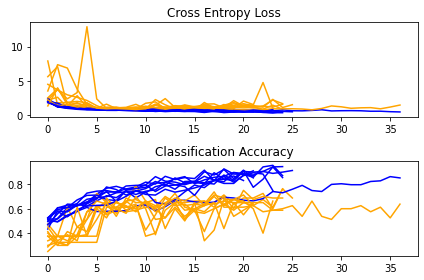

Val Accuracy: mean=72.250, std=3.742, n=10
Test Accuracy: mean=65.610, std=4.424, n=10
dict_values([array([0.76249999, 0.78750002, 0.72500002, 0.66250002, 0.67500001,
       0.75      , 0.72500002, 0.71249998, 0.6875    , 0.73750001]), array([0.58536583, 0.70731705, 0.62195122, 0.70731705, 0.62195122,
       0.67073172, 0.70731705, 0.63414633, 0.60975611, 0.69512194])])


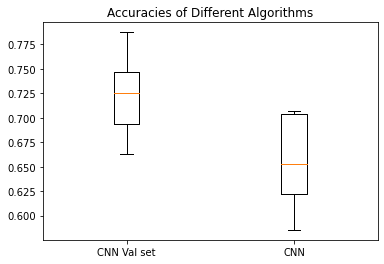

203.72058176994324


In [13]:
#Testing
for i in range(18):
    print("Running slice: %d" % (i*3+78))
    start = time.time()
    scores_val, scores_test = run_model(78+i, [0], 10, 'TESTING_SLICE')
    end = time.time()
    print(end-start)